### Market Data Analysis 

Jay Urbain, PhD

1/18/2017


Creating pandas dataframe with stock data

In [1]:
import pandas as pd
import pandas.io.data as web # Package and modules for importing data   
import datetime
 
# Stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Apple stock data
appl = web.DataReader("AAPL",  # stock ticker
                       "yahoo", # data source - Yahoo Finance
                       start,   # start date
                       end      # end date
                      )
 
type(appl)

/Applications/anaconda/envs/py35/lib/python3.5/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


pandas.core.frame.DataFrame

Displaying the first few rows witht the dataframe head method

In [2]:
appl.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,67649400,103.057063
2016-01-05,105.750000,105.849998,102.410004,102.709999,55791000,100.474523
2016-01-06,100.559998,102.370003,99.870003,100.699997,68457400,98.508268
2016-01-07,98.680000,100.129997,96.430000,96.449997,81094400,94.350769
2016-01-08,98.550003,99.110001,96.760002,96.959999,70798000,94.849671


Ploting stock adjusted closing price using a Matplotlib line chart.

DataFrame object has a convenience method, plot(), which makes creating plots easier.

http://matplotlib.org/api/finance_api.html

Populating the interactive namespace from numpy and matplotlib


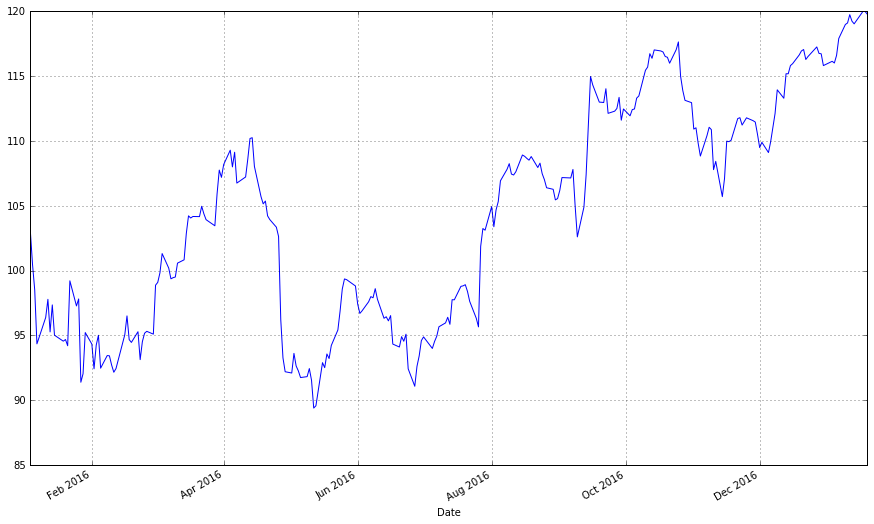

In [3]:
import matplotlib.pyplot as plt   
# needed for plot to appear withing notebook
%matplotlib inline 
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
# Plot the adjusted closing price of AAPL
appl["Adj Close"].plot(grid = True) 

Financial data is often plotted with a Japanese candlestick plot to display all multiple parameters (open, high, low, and close). 

A bit tedious with Matplotlib.

Reference:

http://matplotlib.org/examples/pylab_examples/finance_demo.html

http://matplotlib.org/api/finance_api.html
    

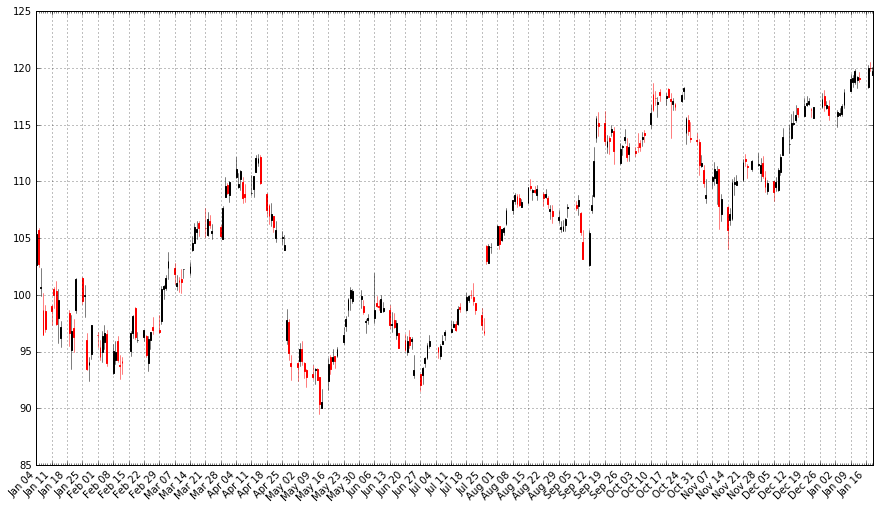

In [4]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(appl)

In [5]:
Plotting multiple parameters

SyntaxError: invalid syntax (<ipython-input-5-be34f5bc1684>, line 1)

In [ ]:
msft = web.DataReader("MSFT", "yahoo", start, end)
goog = web.DataReader("GOOG", "yahoo", start, end)
 
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

In [ ]:
stocks.plot(grid = True)

Plotting absolute value (price) makes the data more difficult to compare. We may be more concerned about the relative change of one set of data relative to anothe. 

For example, we may be more interested in relative change and volatility between two different stocks.

One solution would be to use two different scales when plotting the data.

In [6]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

NameError: name 'stocks' is not defined

A better option is to plot the information that we actually want, i.e.,  stock’s returns. 

$\text{return}_{t,0} = \frac{\text{price}_t}{\text{price}_0} $

This requires transforming the data in the stocks:

In [7]:
# df.apply(arg) will apply the function arg to each column in df, 
# and return a DataFrame with the result
# lambda x is an anonymous function accepting parameter x
# in this case, x will be a pandas Series object and we
# will divide each value by the initial value x[0]
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

NameError: name 'stocks' is not defined

In [8]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)


NameError: name 'stock_return' is not defined

So over the last calendar year, MSFT and AAPL returned ~16 to 17% return. GOOG ~9%. Interesting to see how well correlated the stocks are.

We could also plot the change of each stock per day. I.e., plot the percentage increase of a stock when comparing day $t$ to day $t + 1$, with the formula:

$\text{growth}_t = \frac{\text{price}_{t + 1} - \text{price}_t}{\text{price}_t} $

But change could be thought of differently as:

$\text{increase}_t = \frac{\text{price}_{t} - \text{price}_{t-1}}{\text{price}_t}$ 

These formulas can lead to differing conclusions. Another commonly used method to model the growth of a stock: with log differences.

$\text{change}_t = \log(\text{price}_{t}) - \log(\text{price}_{t - 1})$ 

The $\log$ is the natural log, and our definition does not depend as strongly on whether we use:

$\log(\text{price}_{t}) - \log(\text{price}_{t - 1})$ 

The advantage of using log differences is that this difference can be interpreted as the percentage change in a stock, but does not depend on the denominator of a fraction.


In [9]:
# You can use NumPy's log function, or math's log function 
# NumPy can be faster with vector data
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

NameError: name 'stocks' is not defined

In [10]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)


NameError: name 'stock_change' is not defined

Looking at returns since the begining of the preiod makes the overal trend more apparent. Interesting to observe that AAPL and MSFT appear to be more volatile that GOOG.

Moving Averages

A q-day moving average is, for a series $x_t$ and a point in time t, the average of the past $q$ days, i.e., if $MA^q_t$ denotes a moving average process, then:

$MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}$

Moving averages smooth a series and helps identify trends. The larger q, the greater the smoothing over the series $x_t$. The idea is that moving average processes help identify trends from “noise”. 

pandas provides functionality for easily computing moving averages with the rolling function. 


Here's a 20-day (one month) moving average for the APPL data plotted it alongside the stock candlestick plot.

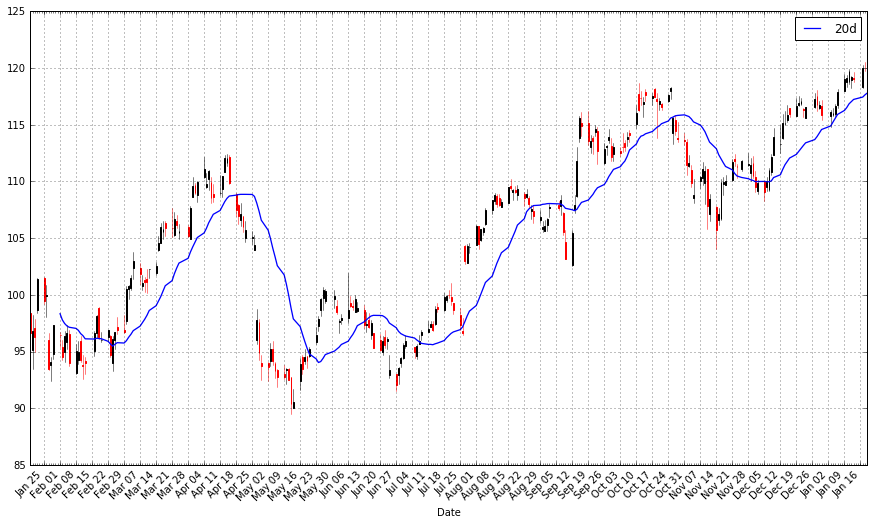

In [11]:
appl["20d"] = np.round(appl["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(appl.loc['2016-01-19':'2017-01-19',:], otherseries = "20d")

Multiple moving averages:

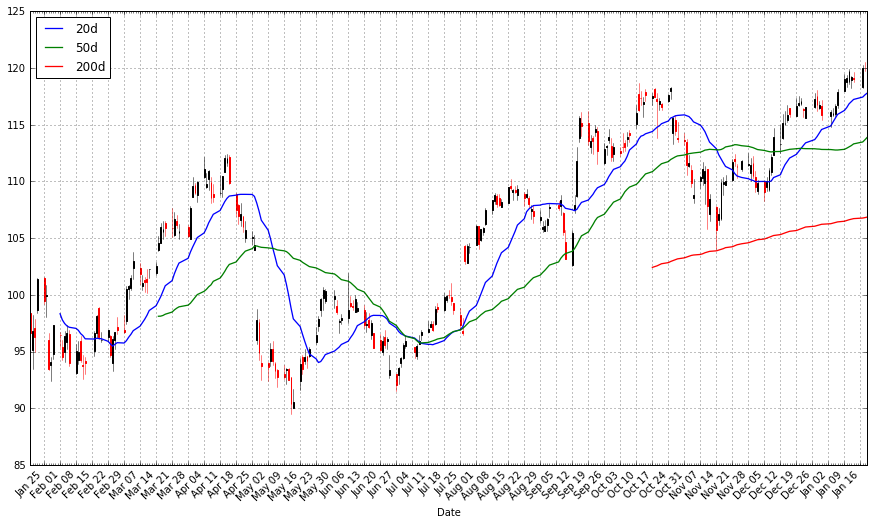

In [12]:
appl["50d"] = np.round(appl["Close"].rolling(window = 50, center = False).mean(), 2)
appl["200d"] = np.round(appl["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(appl.loc['2016-01-19':'2017-01-19',:], otherseries = ["20d", "50d", "200d"])


Notice how I need at least as much data as the moving average filter, to plot the moving average. Traders interpret the crossing points of averages as starts in bullish or bearish trens.